You might need to install this on your system:

apt-get install python3-opencv git

In [ ]:
import os
if not os.path.isdir('k'):
 !git clone -b development15 https://github.com/joaopauloschuler/k-neural-api.git k
else:
 !cd k && git pull
!cd k && pip install .

Cloning into 'k'...
remote: Enumerating objects: 1581, done.
remote: Counting objects: 100% (1030/1030), done.
remote: Compressing objects: 100% (674/674), done.
remote: Total 1581 (delta 747), reused 608 (delta 351), pack-reused 551
Receiving objects: 100% (1581/1581), 15.08 MiB | 13.22 MiB/s, done.
Resolving deltas: 100% (1103/1103), done.
Processing /content/k
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for cai: filename=cai-0.1.6-py3-none-any.whl size=59916 sha256=49715997959b0ae0c505c3ae135ebbc0ec8f0ac12bde9c6240df6f38ea639c1b
  Stored in directory: /tmp/pip-ephem-wheel-cache-ulj7se2l/wheels/c1/8a/57/56dbba25eff58e52e53

In [ ]:
import cai.layers
import cai.datasets
import cai.models
import cai.densenet
import cai.efficientnet
import numpy as np
from tensorflow import keras
import gc
import multiprocessing
import random
import tensorflow as tf
print("Tensorflow version:", tf.version.VERSION)
print("Keras version:", keras.__version__)
print("CPU cores:", multiprocessing.cpu_count())
import psutil
print('RAM:', (psutil.virtual_memory().total / 1e9),'GB')
print(tf.config.list_physical_devices('GPU'))
import matplotlib.pylab as plt

Tensorflow version: 2.7.0
Keras version: 2.7.0
CPU cores: 8
RAM: 54.767017984 GB
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!nvidia-smi

Tue Feb 15 12:47:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from tensorflow.python.profiler.model_analyzer import profile
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder

def get_flops(model):
  forward_pass = tf.function(
      model.call,
      input_signature=[tf.TensorSpec(shape=(1,) + model.input_shape[1:])])

  graph_info = profile(forward_pass.get_concrete_function().graph,
                          options=ProfileOptionBuilder.float_operation())

  # The //2 is necessary since `profile` counts multiply and accumulate
  # as two flops, here we report the total number of multiply accumulate ops
  flops = graph_info.total_float_ops // 2
  return flops

# Download Files and Create Validation and Test Datasets

In [ ]:
verbose=True
root_folder = 'colorectal_5000'
train_dir = root_folder + '/Kather_texture_2016_image_tiles_5000'
val_dir = root_folder + '/val'
test_dir = root_folder + '/test'

url_zip_file = 'https://zenodo.org/record/53169/files/Kather_texture_2016_image_tiles_5000.zip?download=1'
local_zip_file = 'colorectal_5000.zip'
expected_folder_name = root_folder

if not os.path.isdir(root_folder):
  cai.datasets.download_zip_and_extract(url_zip_file, local_zip_file, expected_folder_name, verbose)
  cai.datasets.extract_subset_every(train_dir, val_dir, move_every=10, shift=0, verbose=verbose)
  cai.datasets.extract_subset_every(train_dir, test_dir, move_every=9, shift=0, verbose=verbose)

Downloading:  https://zenodo.org/record/53169/files/Kather_texture_2016_image_tiles_5000.zip?download=1  to  colorectal_5000.zip
Decompressing into:  colorectal_5000
Creating folder colorectal_5000/val
Creating folder colorectal_5000/val/07_ADIPOSE
Creating folder colorectal_5000/val/02_STROMA
Creating folder colorectal_5000/val/08_EMPTY
Creating folder colorectal_5000/val/03_COMPLEX
Creating folder colorectal_5000/val/06_MUCOSA
Creating folder colorectal_5000/val/04_LYMPHO
Creating folder colorectal_5000/val/01_TUMOR
Creating folder colorectal_5000/val/05_DEBRIS
63 files have been moved from colorectal_5000/Kather_texture_2016_image_tiles_5000/07_ADIPOSE to colorectal_5000/val/07_ADIPOSE.
63 files have been moved from colorectal_5000/Kather_texture_2016_image_tiles_5000/02_STROMA to colorectal_5000/val/02_STROMA.
63 files have been moved from colorectal_5000/Kather_texture_2016_image_tiles_5000/08_EMPTY to colorectal_5000/val/08_EMPTY.
63 files have been moved from colorectal_5000/Kat

In [ ]:
!ls -l colorectal_5000/Kather_texture_2016_image_tiles_5000/01_TUMOR/ | wc -l

500


In [ ]:
num_classes = 8
batch_size = 64
epochs = 1000
target_size_x = 224
target_size_y = 224
seed = 12
lab=False
bipolar=False
smart_resize=True

In [ ]:
# load train dataset
x_train, aux_x_val, aux_x_test, y_train, aux_y_val, aux_y_test, class_weight, classes = \
  cai.datasets.load_images_from_folders(seed=seed, root_dir=train_dir, lab=lab, 
  verbose=verbose, bipolar=bipolar, base_model_name='train',
  training_size=1.0, validation_size=0.0, test_size=0.0,
  target_size=(target_size_x, target_size_y), 
  has_training=True, has_validation=False, has_testing=False, 
  smart_resize=smart_resize)

Loading  8  classes.
smart resize is enabled.
loading train images
train shape is: (3992, 224, 224, 3)
Channel  0  min: 0.0  max: 1.0
Channel  1  min: 0.0  max: 1.0
Channel  2  min: 0.0  max: 1.0
Loaded.


In [ ]:
# load validation dataset
aux_x_train, x_val, aux_x_test, aux_y_train, y_val, aux_y_test, class_weight, classes = \
  cai.datasets.load_images_from_folders(seed=seed, root_dir=val_dir, lab=lab, 
  verbose=verbose, bipolar=bipolar, base_model_name='val',
  training_size=0.0, validation_size=1.0, test_size=0.0,
  target_size=(target_size_x, target_size_y), 
  has_training=False, has_validation=True, has_testing=False, 
  smart_resize=smart_resize)

Loading  8  classes.
smart resize is enabled.
loading validation images
validation shape is: (504, 224, 224, 3)
Loaded.


In [ ]:
# Duplicate Validation by Flipping Horizontally
x_val = np.concatenate( (x_val, np.flip(x_val, 2)), axis=0)
y_val = np.concatenate( (y_val, y_val), axis=0)

# Duplicate Validation Again by Flipping Vertically
x_val = np.concatenate( (x_val, np.flip(x_val, 1)), axis=0)
y_val = np.concatenate( (y_val, y_val), axis=0)

print("x_val_shape:", x_val.shape)
print("y_val_shape:", y_val.shape)

x_val_shape: (2016, 224, 224, 3)
y_val_shape: (2016, 8)


In [ ]:
# load test dataset
aux_x_train, aux_x_val, x_test, aux_y_train, aux_y_val, y_test, class_weight, classes = \
  cai.datasets.load_images_from_folders(seed=seed, root_dir=test_dir, lab=lab, 
  verbose=verbose, bipolar=bipolar, base_model_name='test',
  training_size=0.0, validation_size=0.0, test_size=1.0,
  target_size=(target_size_x, target_size_y), 
  has_training=False, has_validation=False, has_testing=True, 
  smart_resize=smart_resize)

Loading  8  classes.
smart resize is enabled.
loading test images
test shape is: (504, 224, 224, 3)
Loaded.


In [ ]:
train_datagen = cai.util.create_image_generator(vertical_flip=True,
  rotation_range=179, width_shift_range=0.3, height_shift_range=0.3,
  channel_shift_range=0.0)
valid_datagen = cai.util.create_image_generator_no_augmentation()
test_datagen = cai.util.create_image_generator_no_augmentation()
cpus_num = max([multiprocessing.cpu_count(), 8])

def cyclical_adv_lrscheduler25(epoch):
    """CAI Cyclical and Advanced Learning Rate Scheduler.
    # Arguments
        epoch: integer with current epoch count.
    # Returns
        float with desired learning rate.
    """
    base_learning = 0.001
    local_epoch = epoch % 25
    result = base_learning
    if local_epoch < 7:
       result = base_learning * (1 + 0.5*local_epoch)
    else:
       result = (base_learning * 4) * ( 0.85**(local_epoch-7) )

    if result < 2.5245e-04:
      result = 2.5245e-04
    return result

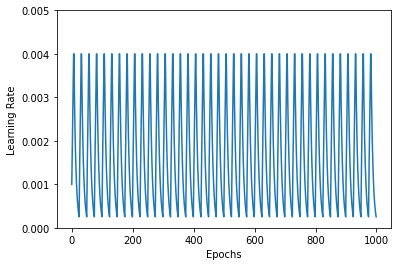

In [ ]:
learning_rate_test = []
for epoch in range(epochs):
  learning_rate_test.append( cyclical_adv_lrscheduler25(epoch) )
plt.figure()
plt.ylabel("Learning Rate")
plt.xlabel("Epochs")
plt.ylim([0.0000,0.005])
plt.plot(learning_rate_test)

In [ ]:
def work_on_keffnet(show_model=False, run_fit=False, test_results=False, calc_f1=False):
  monitor='val_loss'
  if (show_model):
    input_shape = (target_size_x, target_size_y, 3)
  else:
    input_shape = (None, None, 3)
  for kType in [cai.layers.D6v3_16ch()]: # cai.layers.D6v3_16ch(), cai.layers.D6v3_32ch()
      basefilename = '/content/drive/MyDrive/output/JP30N05-'+str(kType)
      best_result_file_name = basefilename+'-best_result.hdf5'
      print('Running: '+basefilename)
      if kType == -1:
        model = cai.efficientnet.EfficientNetB0(
          include_top=True,
          input_shape=input_shape,
          classes=num_classes)
      else:
        model = cai.efficientnet.kEfficientNetB0(
          include_top=True,
          input_shape=input_shape,
          classes=num_classes,
          # skip_stride_cnt=0,
          kType=kType)
        
      optimizer = keras.optimizers.RMSprop()
      model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy'])

      if (show_model):
        model.summary(line_length=180)
        print('model flops:',get_flops(model))

      save_best = keras.callbacks.ModelCheckpoint(
            filepath=best_result_file_name,
            monitor=monitor,
            verbose=1,
            save_best_only=True,
            save_weights_only=False,
            mode='min',
            save_freq='epoch')

      if (run_fit): 
            train_flow = train_datagen.flow(
                x_train, y_train,
                batch_size=batch_size,
                shuffle=True,
                seed=seed
            )
            validation_flow = valid_datagen.flow(
                x_val, y_val,
                batch_size=batch_size,
                shuffle=False,
                seed=seed
            )
            history = model.fit(
              x = train_flow,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=validation_flow,
              callbacks=[save_best, tf.keras.callbacks.LearningRateScheduler(cyclical_adv_lrscheduler25)],
              workers=cpus_num,
              max_queue_size=128
            )
            plt.figure()
            plt.ylabel("Accuracy (training and validation)")
            plt.xlabel("Epochs")
            plt.ylim([0,1])
            plt.plot(history.history["accuracy"])
            plt.plot(history.history["val_accuracy"])
      if (test_results):
        test_flow = test_datagen.flow(
            x_test, y_test,
            batch_size=batch_size,
            shuffle=False,
            seed=seed
        )
        print('Best Model Results: '+best_result_file_name)
        model = cai.models.load_kereas_model(best_result_file_name)
        evaluated = model.evaluate(
            x=test_flow,
            batch_size=batch_size,
            use_multiprocessing=False,
            workers=cpus_num
        )
        for metric, name in zip(evaluated,["loss","acc"]):
              print(name,metric)
      if (calc_f1):
        cai.datasets.test_flips_on_saved_model(x_test, y_test, best_result_file_name, has_flip_x=True, has_flip_y=True, has_bw=True, center_crop=0.15)
      print('Finished: '+basefilename)

# Show Models

In [ ]:
work_on_keffnet(show_model=True, run_fit=False, test_results=False)

Running: /content/drive/MyDrive/output/JP30N05-32
Model: "kEffNet-b0"
____________________________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                              Output Shape                            Param #              Connected to                                                
 input_1 (InputLayer)                                      [(None, 224, 224, 3)]                   0                    []                                                          
                                                                                                                                                                                    
 k_stem_conv_pad (ZeroPadding2D)                           (None, 225, 225, 3)                     0                    ['input_1[0][0]']                                           
                         

# Fitting

Running: /content/drive/MyDrive/output/JP30N05-32
Epoch 1/1000
63/63 [==============================] - ETA: 0s - loss: 2.0931 - accuracy: 0.4228
Epoch 00001: val_loss improved from inf to 2.21721, saving model to /content/drive/MyDrive/output/JP30N05-32-best_result.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


63/63 [==============================] - 75s 579ms/step - loss: 2.0931 - accuracy: 0.4228 - val_loss: 2.2172 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 2/1000
63/63 [==============================] - ETA: 0s - loss: 1.6085 - accuracy: 0.5248
Epoch 00002: val_loss did not improve from 2.21721
63/63 [==============================] - 26s 384ms/step - loss: 1.6085 - accuracy: 0.5248 - val_loss: 2.2549 - val_accuracy: 0.1250 - lr: 0.0015
Epoch 3/1000
63/63 [==============================] - ETA: 0s - loss: 1.3389 - accuracy: 0.5378
Epoch 00003: val_loss did not improve from 2.21721
63/63 [==============================] - 26s 384ms/step - loss: 1.3389 - accuracy: 0.5378 - val_loss: 2.2786 - val_accuracy: 0.1250 - lr: 0.0020
Epoch 4/1000
63/63 [==============================] - ETA: 0s - loss: 1.2668 - accuracy: 0.5884
Epoch 00004: val_loss did not improve from 2.21721
63/63 [==============================] - 26s 386ms/step - loss: 1.2668 - accuracy: 0.5884 - val_loss: 2.2687 - val_accuracy:

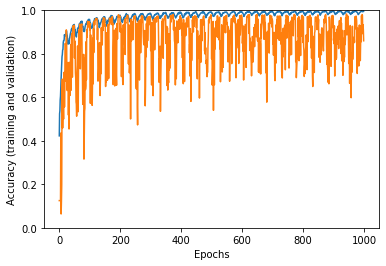

In [17]:
work_on_keffnet(show_model=False, run_fit=True, test_results=True)

# Test Results

In [18]:
work_on_keffnet(show_model=False, run_fit=False, test_results=True)

Running: /content/drive/MyDrive/output/JP30N05-32
Best Model Results: /content/drive/MyDrive/output/JP30N05-32-best_result.hdf5
8/8 [==============================] - 4s 67ms/step - loss: 0.0918 - accuracy: 0.9762
loss 0.09175471216440201
acc 0.976190447807312
Finished: /content/drive/MyDrive/output/JP30N05-32


In [19]:
work_on_keffnet(show_model=False, run_fit=False, test_results=False, calc_f1=True)

Running: /content/drive/MyDrive/output/JP30N05-32
Test Original
              precision    recall  f1-score   support

           0     1.0000    0.9683    0.9839        63
           1     0.9688    0.9841    0.9764        63
           2     0.9091    0.9524    0.9302        63
           3     0.9524    0.9524    0.9524        63
           4     1.0000    0.9683    0.9839        63
           5     1.0000    1.0000    1.0000        63
           6     1.0000    0.9841    0.9920        63
           7     0.9844    1.0000    0.9921        63

    accuracy                         0.9762       504
   macro avg     0.9768    0.9762    0.9764       504
weighted avg     0.9768    0.9762    0.9764       504

Test Flip X
              precision    recall  f1-score   support

           0     1.0000    0.9683    0.9839        63
           1     1.0000    0.9524    0.9756        63
           2     0.8824    0.9524    0.9160        63
           3     0.9375    0.9524    0.9449        63
  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
